# Introduction

Competition: Time Series  

https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/  

About Practice Problem: Time Series  
Time Series forecasting & modeling plays an important role in data analysis. Time series analysis is a specialized branch of statistics used extensively in fields such as Econometrics & Operation Research.  

Time Series is being widely used in analytics & data science. This is specifically designed time series problem for you and challenge is to forecast traffic.  

Rules:  
1. One person cannot participate with more than one user accounts.
2. This is proprietary dataset, you can only use for this hackathon (Analytics Vidhya Datahack Platform) not for any other reuse
3. You are free to use any tool and machine you have rightful access to.
4. You can use any programming language or statistical software.
5. You are free to use solution checker as many times as you want.

In [274]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.model_selection import RandomizedSearchCV as rscv
#import xgboost as xgb

# pd.options.display.max_columns = None
# pd.options.display.max_rows = 56

filepath = 'D:/code/Data/time_series_datahack/'

data = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')
sample = pd.read_csv(f'{filepath}sample_submission.csv')

# Data Exploration

In [275]:
display(data)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


Oh. There's only 1 input and 1 output.  

Well, that may not seem like a lot, but think of all the FEATURE GENERATION you can do!!!
1. Year, Month, Day, Hour
2. Traffic in a preceding window of time (like traffic in the past x minutes)
3. Holidays!
4. More!!!

Make sure to train the FINAL model on ALL the data, after all parameters have been selected!!!

In [276]:
data.describe()

#Why the crap doesn't it describe the Datetime? Maybe because they're all unique.

,ID,Count
count,18288.000000,18288.000000
mean,9143.500000,138.958115
std,5279.435197,153.467461
min,0.000000,2.000000
25%,4571.750000,22.000000
50%,9143.500000,84.000000
75%,13715.250000,210.000000
max,18287.000000,1244.000000


# Data Cleaning

In [277]:
display(data.isnull().sum())

ID          0
Datetime    0
Count       0
dtype: int64

Nice! No missing data. Easy Mode!        

We should check if there's any gaps in the dates, or if it's a continuous run.  
The dates are spread out at hour intervals. Looks like 2 years of data. Dope!!

# Data Plotting

In [278]:
#Let's start with a cut of the data, this will take forever to graph

x1 = data.loc[:100, 'Datetime']

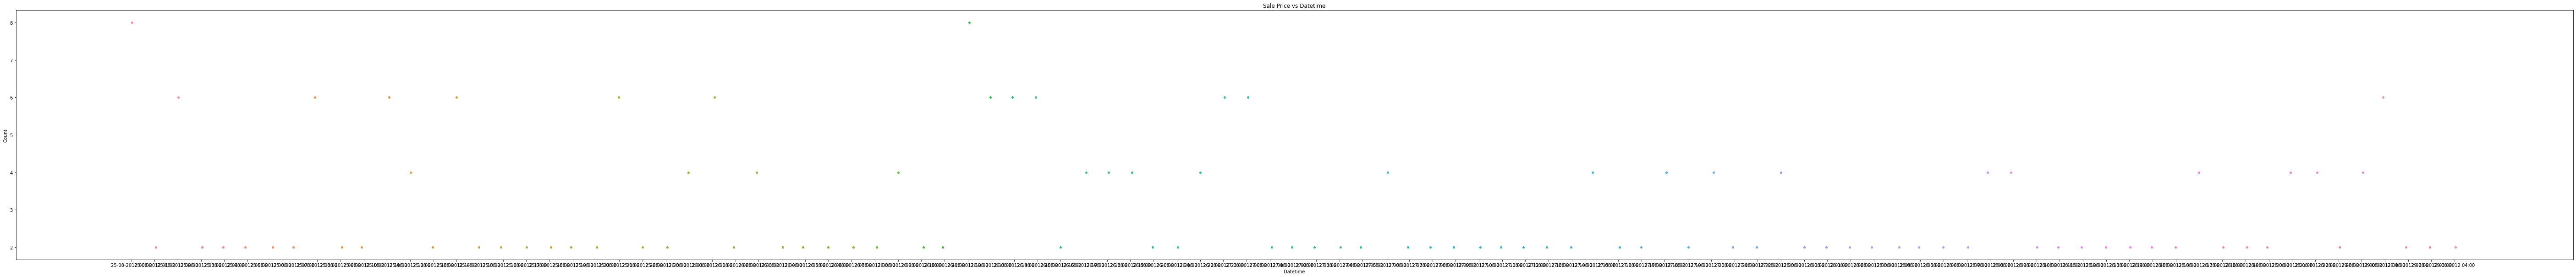

--- 8.641271114349365 seconds ---
--- 0.14402118523915608 minutes ---


In [279]:
#Let's time this, takes forever

start_time = time.time()


plt.figure(figsize = (100, 10))
graph = sns.stripplot(x = x1, y = 'Count', hue = None, data = data)
plt.title(f'Sale Price vs Datetime')
graph.autoscale()
plt.show()

end_time = time.time()
total_time = end_time - start_time 

print(f'--- {total_time} seconds ---')
print(f'--- {total_time / 60} minutes ---')

This is very slow, so I won't plot that many. Could be interesting to build someday

# Feature Generation

Let's do some very basic feature generation:  
1. Year
2. Month
3. Day
4. Hour

In [280]:
# First, convert from string to the datetime object in Pandas. This makes it easier to find the year, month, etc...
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Now, add the obvious features
data['Year'] = data['Datetime'].apply(lambda x: x.year)
data['Month'] = data['Datetime'].apply(lambda x: x.month)
data['Day'] = data['Datetime'].apply(lambda x: x.day)
data['Hour'] = data['Datetime'].apply(lambda x: x.hour)

# Also, do it all for test data while we're at it
test['Datetime'] = pd.to_datetime(test['Datetime'])

# Now, add the obvious features
test['Year'] = test['Datetime'].apply(lambda x: x.year)
test['Month'] = test['Datetime'].apply(lambda x: x.month)
test['Day'] = test['Datetime'].apply(lambda x: x.day)
test['Hour'] = test['Datetime'].apply(lambda x: x.hour)


display(data)

,ID,Datetime,Count,Year,Month,Day,Hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4
...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22


# More plotting

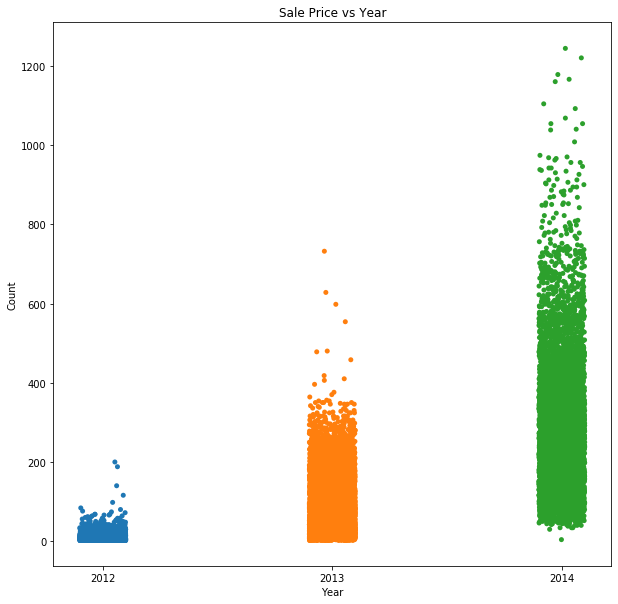

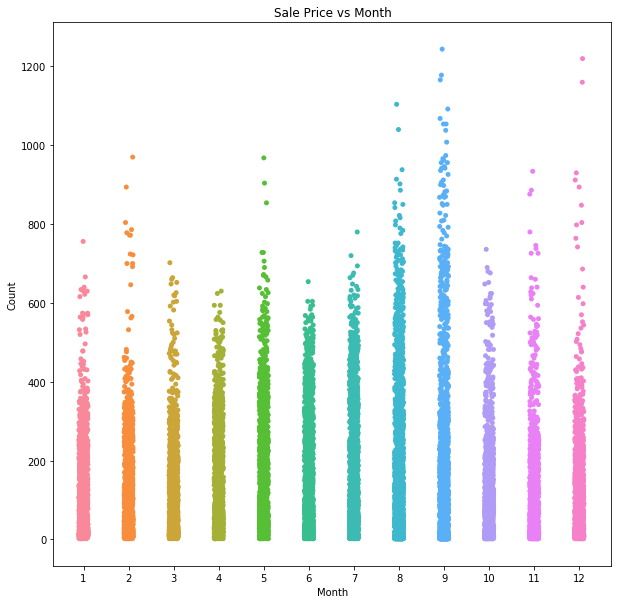

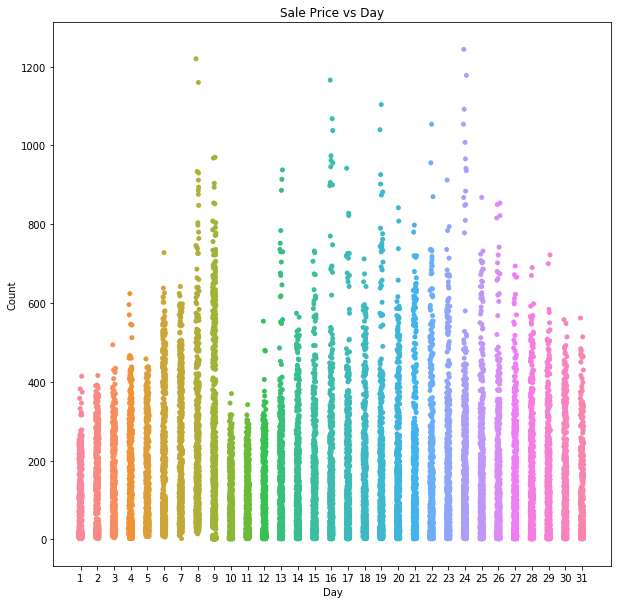

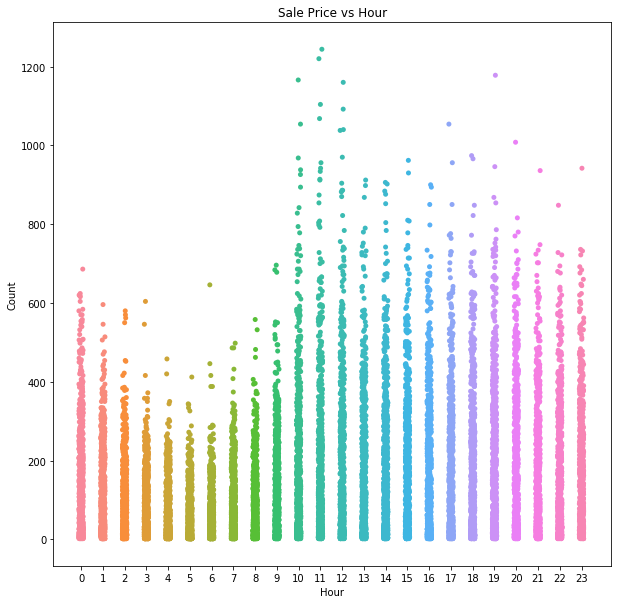

In [281]:
for feature in ['Year', 'Month', 'Day', 'Hour']:

    plt.figure(figsize = (10, 10))
    graph = sns.stripplot(x = feature, y = 'Count', hue = None, data = data)
    plt.title(f'Sale Price vs {feature}')
    graph.autoscale()
    plt.show()

# Model Training 1

Let's just dump everything into LightGBM and see what happens!!!  

Don't judge me, I'm lazy 😁

In [282]:
# Train Valid Split, I'll do k-fold later

# It's going to be important to keep leakage in mind, since this data is time based.

# Note, we don't need to split test data, as the competition has furnished us with test data.

train, valid = train_test_split(data, shuffle = False, test_size = .2)

X_train = train.loc[:, 'Year':]
y_train = train.loc[:, 'Count']

X_valid = valid.loc[:, 'Year':]
y_valid = valid.loc[:, 'Count']

In [283]:
model = lgb.LGBMRegressor(num_iterations = 5000)

model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose = True)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for the dump model is {error}')



C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 90266
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 83027.2
[3]	valid_0's l2: 77643.8
[4]	valid_0's l2: 72064
[5]	valid_0's l2: 68068.9
[6]	valid_0's l2: 63949.6
[7]	valid_0's l2: 60622.5
[8]	valid_0's l2: 57595.1
[9]	valid_0's l2: 55229.6
[10]	valid_0's l2: 52730.3
[11]	valid_0's l2: 50662.6
[12]	valid_0's l2: 49131.6
[13]	valid_0's l2: 47884.3
[14]	valid_0's l2: 46254.1
[15]	valid_0's l2: 45294.8
[16]	valid_0's l2: 44279.2
[17]	valid_0's l2: 43369.1
[18]	valid_0's l2: 42578
[19]	valid_0's l2: 41929.2
[20]	valid_0's l2: 41314.2
[21]	valid_0's l2: 40864.4
[22]	valid_0's l2: 40472.6
[23]	valid_0's l2: 39698.4
[24]	valid_0's l2: 39055.8
[25]	valid_0's l2: 38663.3
[26]	valid_0's l2: 38322.1
[27]	valid_0's l2: 37917
[28]	valid_0's l2: 37684.4
[29]	valid_0's l2: 37405.2
[30]	valid_0's l2: 37241.9
[31]	valid_0's l2: 37119.8
[32]	valid_0's l2: 36793.4
[33]	valid_0's l2: 36627
[34]	valid_0's l2: 36521.8
[35]	valid_0's l2: 36441.8
[36]	valid_0'

'RMSE for the dump model is 186.99562660321007'

In [284]:
# Is this actually an acceptable way to calculate percent error? Better check that later.

mean = data.Count.mean()
percent_error = error / mean * 100

display(f'RMSE for the dump model is {error:.2f}')
display(f'Percent Error for the dump model is {percent_error:.2f}%')

'RMSE for the dump model is 187.00'

'Percent Error for the dump model is 134.57%'

Well, not terrible for a basic dump, but we could do a whole lot better I'm sure!!! About 23%

But, let's see how we're doing so far. Let's retrain on the whole data, and do a sample submission. Note that retraining on all the data means no early stopping rounds.

In [285]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':]

model = lgb.LGBMRegressor(num_iterations = 2000)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)


output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit1.csv',index=False, header =1)

C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


We did pretty good the first time! Score of 259.131555128961. Place was like 448 I think.

# More Feature Generation

Dude, we forgot to do DAY OF THE WEEK. OBVIOUSLY THAT'S GOING TO BE HOT!!!!

In [286]:
data['Dayofweek'] = data['Datetime'].apply(lambda x: x.dayofweek)

test['Dayofweek'] = test['Datetime'].apply(lambda x: x.dayofweek)

display(data)

,ID,Datetime,Count,Year,Month,Day,Hour,Dayofweek
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5
...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3


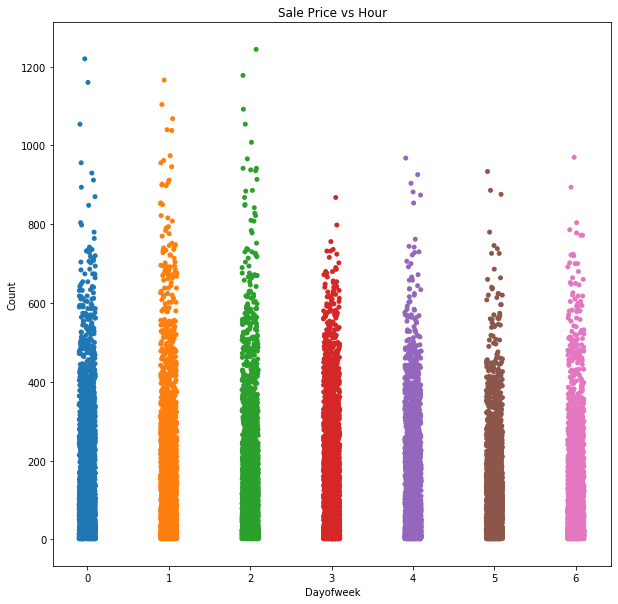

In [287]:
plt.figure(figsize = (10, 10))
graph = sns.stripplot(x = 'Dayofweek', y = 'Count', hue = None, data = data)
plt.title(f'Sale Price vs {feature}')
graph.autoscale()
plt.show()

# Model Training 2

Let's train again!!

In [288]:
# Train Valid Split, I'll do k-fold later

# It's going to be important to keep leakage in mind, since this data is time based.

# Note, we don't need to split test data, as the competition has furnished us with test data.

train, valid = train_test_split(data, shuffle = False, test_size = .2)

X_train = train.loc[:, 'Year':]
y_train = train.loc[:, 'Count']

X_valid = valid.loc[:, 'Year':]
y_valid = valid.loc[:, 'Count']

display(train)
display(valid)

,ID,Datetime,Count,Year,Month,Day,Hour,Dayofweek
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5
...,...,...,...,...,...,...,...,...
14625,14625,2014-04-26 09:00:00,154,2014,4,26,9,5
14626,14626,2014-04-26 10:00:00,200,2014,4,26,10,5
14627,14627,2014-04-26 11:00:00,200,2014,4,26,11,5
14628,14628,2014-04-26 12:00:00,228,2014,4,26,12,5


,ID,Datetime,Count,Year,Month,Day,Hour,Dayofweek
14630,14630,2014-04-26 14:00:00,204,2014,4,26,14,5
14631,14631,2014-04-26 15:00:00,172,2014,4,26,15,5
14632,14632,2014-04-26 16:00:00,184,2014,4,26,16,5
14633,14633,2014-04-26 17:00:00,124,2014,4,26,17,5
14634,14634,2014-04-26 18:00:00,190,2014,4,26,18,5
...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3


In [289]:
model = lgb.LGBMRegressor(num_iterations = 2000)

model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose = True)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for the dump model 2 is {error}')



C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 91612.2
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 84753.5
[3]	valid_0's l2: 79424
[4]	valid_0's l2: 74524.8
[5]	valid_0's l2: 69849.3
[6]	valid_0's l2: 66300.4
[7]	valid_0's l2: 63653.6
[8]	valid_0's l2: 60760.3
[9]	valid_0's l2: 58199.4
[10]	valid_0's l2: 56389.4
[11]	valid_0's l2: 54504.7
[12]	valid_0's l2: 52430.2
[13]	valid_0's l2: 50899.7
[14]	valid_0's l2: 49731
[15]	valid_0's l2: 48601.4
[16]	valid_0's l2: 47563.8
[17]	valid_0's l2: 46248.8
[18]	valid_0's l2: 45407.6
[19]	valid_0's l2: 44985.1
[20]	valid_0's l2: 44419.8
[21]	valid_0's l2: 43721.2
[22]	valid_0's l2: 43015.9
[23]	valid_0's l2: 42483.7
[24]	valid_0's l2: 41935.8
[25]	valid_0's l2: 41492.6
[26]	valid_0's l2: 40450.5
[27]	valid_0's l2: 40069.5
[28]	valid_0's l2: 39491.6
[29]	valid_0's l2: 38949.8
[30]	valid_0's l2: 38774.8
[31]	valid_0's l2: 38606.1
[32]	valid_0's l2: 38229.4
[33]	valid_0's l2: 38058.6
[34]	valid_0's l2: 37944.6
[35]	valid_0's l2: 37744.5
[36]	va

'RMSE for the dump model 2 is 185.58934502375385'

In [290]:
# Is this actually an acceptable way to calculate percent error? Better check that later.

mean = data.Count.mean()
percent_error = error / mean * 100

display(f'RMSE for the dump model is {error:.2f}')
display(f'Percent Error for the dump model is {percent_error:.2f}%')

'RMSE for the dump model is 185.59'

'Percent Error for the dump model is 133.56%'

Nice! 20%, slight improvement.

Let's see how we're doing so far. Let's retrain on the whole data, and do a sample submission. Note that retraining on all the data means no early stopping rounds.

In [291]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':]

model = lgb.LGBMRegressor(num_iterations = 2000)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)


output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit2.csv',index=False, header =1)

C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [292]:
submit1 = pd.read_csv(f'{filepath}submit1.csv')
submit2 = pd.read_csv(f'{filepath}submit2.csv')

Nice! Improved on leaderboard. Up to 416 place (score of 225.7233529740)

# Feature Generation 3

In [293]:
data['Dayofyear'] = data['Datetime'].apply(lambda x: x.dayofyear)
data['Week'] = data['Datetime'].apply(lambda x: x.week)
data['lag_1'] = data['Count'].shift(1)
data['lag_2'] = data['Count'].shift(2)
data['lag_3'] = data['Count'].shift(3)
data['lag_4'] = data['Count'].shift(4)
data['lag_5'] = data['Count'].shift(5)
data['lag_6'] = data['Count'].shift(6)
data['lag_7'] = data['Count'].shift(7)

test['Dayofyear'] = test['Datetime'].apply(lambda x: x.dayofyear)
test['Week'] = test['Datetime'].apply(lambda x: x.week)
# test['lag_1'] = test['Count'].shift(1)
# test['lag_2'] = test['Count'].shift(2)
# test['lag_3'] = test['Count'].shift(3)
# test['lag_4'] = test['Count'].shift(4)
# test['lag_5'] = test['Count'].shift(5)
# test['lag_6'] = test['Count'].shift(6)
# test['lag_7'] = test['Count'].shift(7)

display(data)

,ID,Datetime,Count,Year,Month,Day,Hour,Dayofweek,Dayofyear,Week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,238,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,238,34,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,238,34,2.0,8.0,NaN,NaN,NaN,NaN,NaN
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,238,34,6.0,2.0,8.0,NaN,NaN,NaN,NaN
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,238,34,2.0,6.0,2.0,8.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3,268,39,680.0,622.0,654.0,686.0,616.0,642.0,672.0
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3,268,39,868.0,680.0,622.0,654.0,686.0,616.0,642.0
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3,268,39,732.0,868.0,680.0,622.0,654.0,686.0,616.0
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3,268,39,702.0,732.0,868.0,680.0,622.0,654.0,686.0


# Model Training 3

In [294]:
# Train Valid Split, I'll do k-fold later

# It's going to be important to keep leakage in mind, since this data is time based.

# Note, we don't need to split test data, as the competition has furnished us with test data.

train, valid = train_test_split(data, shuffle = False, test_size = .2)

X_train = train.loc[:, 'Year':]
y_train = train.loc[:, 'Count']

X_valid = valid.loc[:, 'Year':]
y_valid = valid.loc[:, 'Count']

In [295]:
model = lgb.LGBMRegressor(num_iterations = 5000)

model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose = True)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for the dump model 3 is {error}')



C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 85020.2
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 73670.3
[3]	valid_0's l2: 63980
[4]	valid_0's l2: 56446.9
[5]	valid_0's l2: 49796
[6]	valid_0's l2: 44147
[7]	valid_0's l2: 39499.6
[8]	valid_0's l2: 36072.4
[9]	valid_0's l2: 32674.2
[10]	valid_0's l2: 30075.5
[11]	valid_0's l2: 27568.5
[12]	valid_0's l2: 25469.6
[13]	valid_0's l2: 23874.8
[14]	valid_0's l2: 22521.6
[15]	valid_0's l2: 21303.6
[16]	valid_0's l2: 20069.1
[17]	valid_0's l2: 19316.1
[18]	valid_0's l2: 18559.6
[19]	valid_0's l2: 17691.9
[20]	valid_0's l2: 17210.2
[21]	valid_0's l2: 16547.9
[22]	valid_0's l2: 15881.2
[23]	valid_0's l2: 15486.9
[24]	valid_0's l2: 15082.1
[25]	valid_0's l2: 14693.1
[26]	valid_0's l2: 14272.5
[27]	valid_0's l2: 14038.3
[28]	valid_0's l2: 13676.6
[29]	valid_0's l2: 13360.8
[30]	valid_0's l2: 13144
[31]	valid_0's l2: 13083.9
[32]	valid_0's l2: 13074.8
[33]	valid_0's l2: 13069.6
[34]	valid_0's l2: 12864.1
[35]	valid_0's l2: 12730.7
[36]	valid_

'RMSE for the dump model 3 is 105.7068961484'

In [296]:
# Is this actually an acceptable way to calculate percent error? Better check that later.

mean = data.Count.mean()
percent_error = error / mean * 100

display(f'RMSE for the dump model 3 is {error:.2f}')
display(f'Percent Error for the dump model 3 is {percent_error:.2f}%')

'RMSE for the dump model 3 is 105.71'

'Percent Error for the dump model 3 is 76.07%'

Nice! 20%, slight improvement.

Let's see how we're doing so far. Let's retrain on the whole data, and do a sample submission. Note that retraining on all the data means no early stopping rounds.

In [297]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':]

model = lgb.LGBMRegressor(num_iterations = 5000)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)


output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit3.csv',index=False, header =1)

C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


ValueError: Number of features of the model must match the input. Model n_features_ is 14 and input n_features is 7 

Let's see how this one does.  



In [ ]:
submit1 = pd.read_csv(f'{filepath}submit1.csv')
submit2 = pd.read_csv(f'{filepath}submit2.csv')
submit3 = pd.read_csv(f'{filepath}submit3.csv')

display(submit1)
display(submit2)
display(submit3)

# Feature Importance

Let's dig into this code a bit. Which features were the most important?

In [ ]:
# This isn't quite working, but whatever

importance = pd.DataFrame()
pairs = zip(['Year', 'Month', 'Day', 'Hour', 'Dayofweek'], model.feature_importances_)
print([x for x in pairs])
for x, y in pairs:
    importance[x] = y
    
display(importance)

# Correlation

In [ ]:
corr = data.corr()
display(corr)

plt.figure(figsize = (10, 10))
sns.heatmap(corr)

plt.show()

# XGBoost

Let's compare LightGBM to XGBoost

In [ ]:
# # Train Valid Split, I'll do k-fold later

# # It's going to be important to keep leakage in mind, since this data is time based.

# # Note, we don't need to split test data, as the competition has furnished us with test data.

# train, valid = train_test_split(data, test_size = .2)

# X_train = train.loc[:, 'Year':'Dayofweek']
# y_train = train.loc[:, 'Count']

# X_valid = valid.loc[:, 'Year':'Dayofweek']
# y_valid = valid.loc[:, 'Count']

# model = xgb.XGBRegressor(num_iterations = 5000)

# model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose = True)

# valid_pred = model.predict(X_valid)
# error = np.sqrt(mse(valid_pred, y_valid))

# print('')

# display(f'RMSE for the dump model is {error}')



# # Is this actually an acceptable way to calculate percent error? Better check that later.

# mean = data.Count.mean()
# percent_error = error / mean * 100

# display(f'RMSE for the dump model is {error:.2f}')
# display(f'Percent Error for the dump model is {percent_error:.2f}%')


# X_data = data.loc[:, 'Year':'Hour']
# y_data = data.loc[:, 'Count']

# X_test = test.loc[:, 'Year':'Hour']

# model = lgb.LGBMRegressor(num_iterations = 2000)

# model.fit(X_data, y_data, verbose = False)

# predict = model.predict(X_test)


# output = pd.DataFrame({'ID': test.ID, 'Count': predict})

# output.to_csv(f'{filepath}submit15.csv',index=False, header =1)

# Cross Validation

This time, don't split the data. Use built in k-fold. We'll try 5 and 10 folds.

In [ ]:
# We have to make a LightGBM dataset for this to work

X_data = data.loc[:, 'Year':'Dayofweek']
y_data = data.loc[:, 'Count']

lgbdata = lgb.Dataset(X_data, y_data)

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'num_iterations' : 5000
}



model = lgb.cv(params, lgbdata, early_stopping_rounds=30, stratified = False)

display(model)


# valid_pred = model.predict(X_valid)
# error = np.sqrt(mse(valid_pred, y_valid))



# print('')

# display(f'RMSE for the dump model 2 is {error}')



Ok, I'm confused. What is CV? What is happening here? What are these results???  

What I was hoping was that I could train the model, with early stopping, and it would automatically slice the data into folds and train 5 times and average the models...

No idea what it's doing now.

In [ ]:
# Is this actually an acceptable way to calculate percent error? Better check that later.

mean = data.Count.mean()
percent_error = error / mean * 100

display(f'RMSE for the dump model is {error:.2f}')
display(f'Percent Error for the dump model is {percent_error:.2f}%')



Let's see how we're doing so far. Let's retrain on the whole data, and do a sample submission. Note that retraining on all the data means no early stopping rounds.

In [ ]:
X_data = data.loc[:, 'Year':'Dayofweek']
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':'Dayofweek']

model = lgb.LGBMRegressor(num_iterations = 2000)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)


output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit3.csv',index=False, header =1)

# Hyperparameter Tuning

You know what time it is...

HYPERPARAMETER TUNING TIME!!!!!!